## Copyright 2023 Google LLC

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install -r requirements.txt
!pip install -U transformers diffusers
!pip install -y torch torchvision torchaudio
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!python3 -m pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.1.0
    Uninstalling fsspec-2023.1.0:
      Successfully uninstalled fsspec-2023.1.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 93.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 100.8 MB/s eta 0:00:

# StyleAligned over SDXL from input image

#### Model Load 

In [2]:
from diffusers import StableDiffusionXLPipeline, DDIMScheduler
import torch
import mediapy
import sa_handler
import math


scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
    clip_sample=False, set_alpha_to_one=False)

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True,
    scheduler=scheduler
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Ref image load and inversion

100%|██████████| 50/50 [00:09<00:00,  5.14it/s]



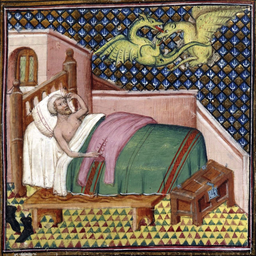

In [3]:
# DDIM inversion

from diffusers.utils import load_image
import inversion
import numpy as np

src_style = "medieval painting"
src_prompt = f'Man laying in a bed, {src_style}.'
image_path = './example_image/medieval-bed.jpeg'

num_inference_steps = 50
x0 = np.array(load_image(image_path).resize((1024, 1024)))
zts = inversion.ddim_inversion(pipeline, x0, src_prompt, num_inference_steps, 2)
mediapy.show_image(x0, title="innput reference image", height=256)

  0%|          | 0/50 [00:00<?, ?it/s]


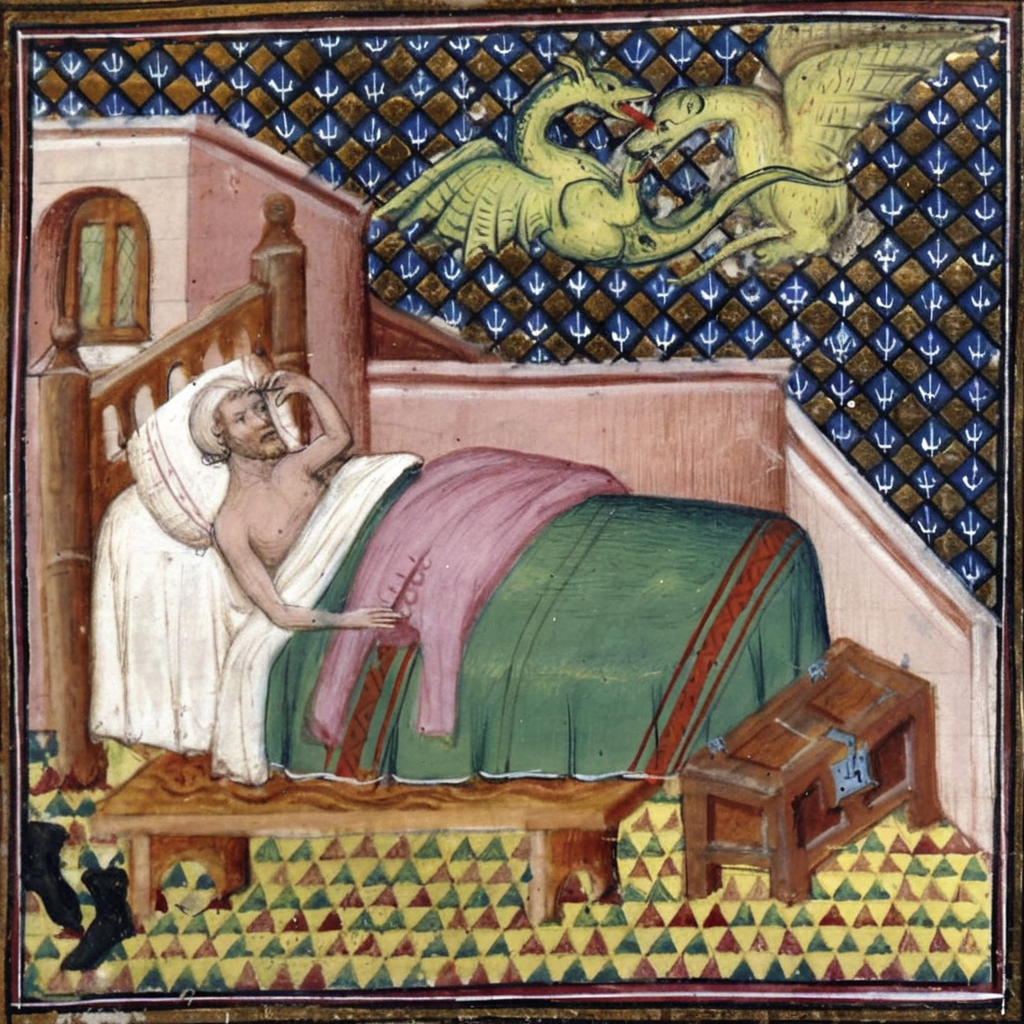
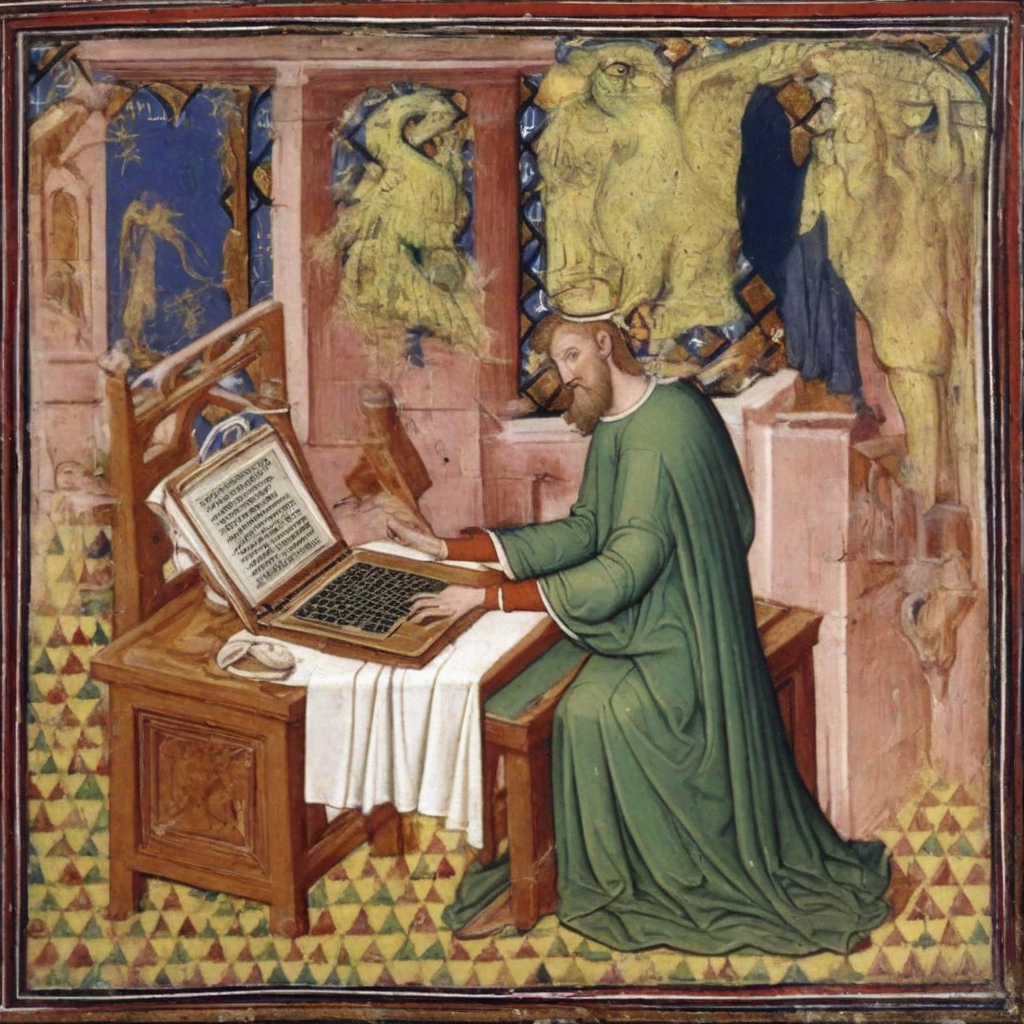
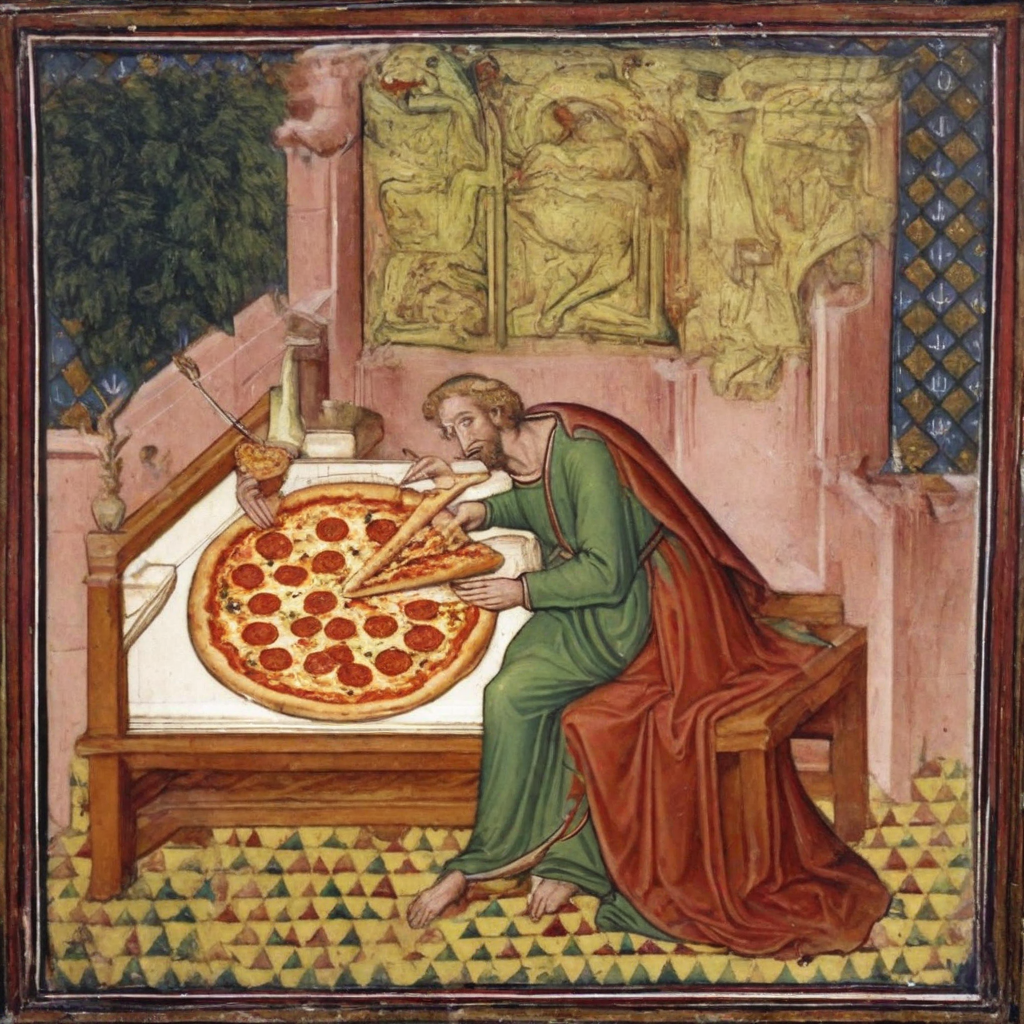
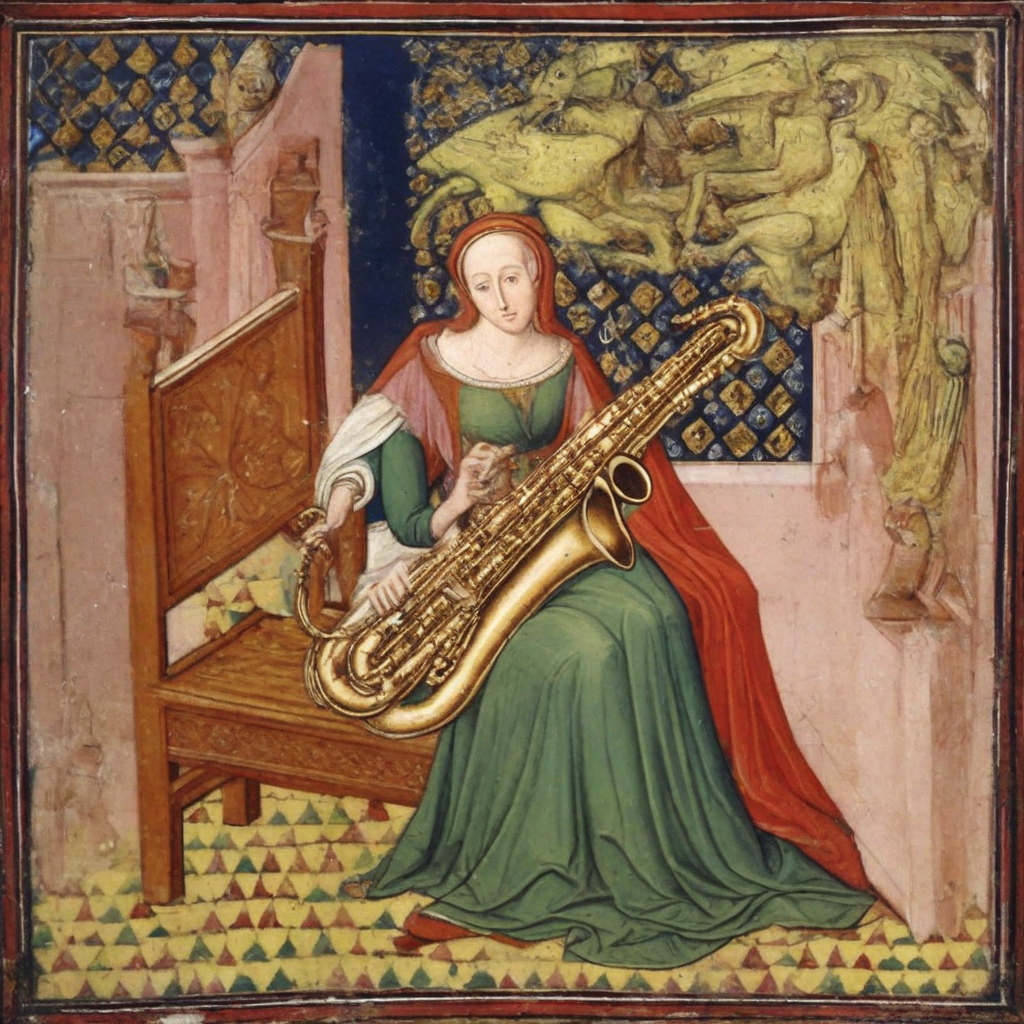

In [4]:
prompts = [
    src_prompt,
    "A man working on a laptop",
    "A man eats pizza",
    "A woman playig on saxophone",
]

# some parameters you can adjust to control fidelity to reference
shared_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
shared_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# for very famouse images consider supressing attention to refference, here is a configuration example:
# shared_score_shift = np.log(1)
# shared_score_scale = 0.5

for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

handler = sa_handler.Handler(pipeline)
sa_args = sa_handler.StyleAlignedArgs(
    share_group_norm=True, share_layer_norm=True, share_attention=True,
    adain_queries=True, adain_keys=True, adain_values=False,
    shared_score_shift=shared_score_shift, shared_score_scale=shared_score_scale,)
handler.register(sa_args)

zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(10)

latents = torch.randn(len(prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                      dtype=pipeline.unet.dtype,).to('cuda:0')
latents[0] = zT

images_a = pipeline(prompts, latents=latents,
                    callback_on_step_end=inversion_callback,
                    num_inference_steps=num_inference_steps, guidance_scale=10.0).images

handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])